In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [107]:
def deep_kernel_cov(N, L, D, num_reps=250, nonlin = 'relu'):
    
    if nonlin == 'relu':
        phi_fn = lambda h: np.sqrt(2.0) * h * (h > 0.0)
        dphi_fn = lambda h: np.sqrt(2.0) * (h>0.0)
    else:
        phi_fn = lambda h: 1.0 * h
        dphi_fn = lambda h: 1.0
        
    all_Phi = np.zeros((L, num_reps))
    all_G = np.zeros((L,num_reps))
    for n in range(num_reps):
        x = np.random.standard_normal(D)
        x = x/np.sqrt(np.dot(x,x))
        all_h = []
        all_W = []
        all_W += [np.random.standard_normal((N,D))]
        for l in range(L-1):
            all_W += [np.random.standard_normal((N,N))]
        all_W += [np.random.standard_normal(N)]
        
        h = all_W[0] @ x
        all_h += [h]
        phi = phi_fn(h)
        Phi1 = 1/N * np.dot(phi, phi)
        all_Phi[0,n] = Phi1
        for l in range(L-1):
            h =  1/np.sqrt(N) * all_W[l+1] @ phi
            all_h += [h]
            phi = phi_fn(h)
            all_Phi[l+1,n] = 1/N * np.dot(phi,phi)
        
        g = dphi_fn(all_h[-1]) * all_W[-1]
        all_G[-1,n] = 1/N * np.dot(g,g)
        for l in range(L-1):
            z = 1/np.sqrt(N) * all_W[-2-l].T @ g
            g = dphi_fn(all_h[-l-2]) * z
            all_G[-l-2,n] = 1/N * np.dot(g,g)
            
    mean_Phi = all_Phi.mean(axis = 1)
    dPhi = all_Phi - mean_Phi[:,np.newaxis]
    Cov = 1/num_reps * dPhi @ dPhi.T
    mean_G = all_G.mean(axis = 1)
    dG = all_G - mean_G[:,np.newaxis]
    Cov_g = 1/num_reps* dG @ dG.T
    return mean_Phi, Cov, mean_G, Cov_g

def theory(N, L, nonlin= 'relu'):
    cov_th = np.zeros((L,L))
    cov_th_g = np.zeros((L,L))
    if nonlin == 'relu':
        V = 5.0
    else:
        V = 2.0
    for l in range(L):
        for ll in range(L):
            cov_th[l,ll] = V / N * min(l+1, ll+1)
            lminus = L-l
            llminus = L-ll
            cov_th_g[l,ll] = V/N * min(lminus, llminus)
    return np.ones(L), cov_th, np.ones(L), cov_th_g


N = 250
L = 10
D = 100

mean, cov, _, cov_g = deep_kernel_cov(N, L, D, num_reps = 500)
mean_th, cov_th, _, cov_th_g = theory(N,L)




In [48]:

_, cov_linear = deep_kernel_cov(N, L, D,nonlin = 'linear')
_, cov_th_linear = theory(N,L, nonlin = 'linear')

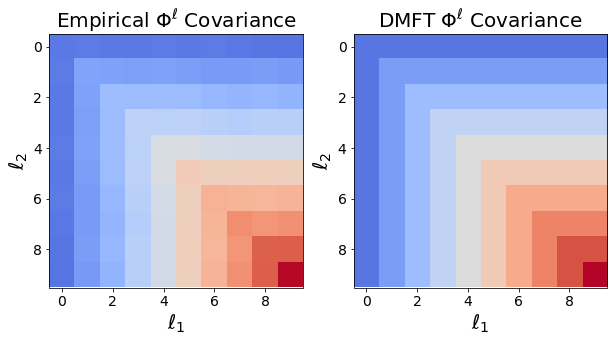

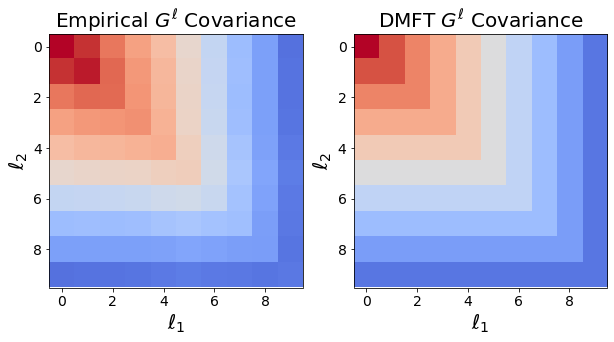

In [108]:
plt.rcParams.update({'font.size': 14})

vmin = 0.1/N 
vmax = 50.0/N
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Empirical $\Phi^{\ell}$ Covariance',fontsize =20)
plt.imshow(cov, cmap = 'coolwarm', vmin = vmin, vmax =vmax)
plt.xlabel(r'$\ell_1$',fontsize = 20)
plt.ylabel(r'$\ell_2$',fontsize=20)
#plt.show()
plt.subplot(1,2,2)
plt.title('DMFT $\Phi^{\ell}$ Covariance',fontsize = 20)
plt.imshow(cov_th, cmap = 'coolwarm', vmin = vmin, vmax =vmax)
plt.xlabel(r'$\ell_1$',fontsize = 20)
plt.ylabel(r'$\ell_2$',fontsize=20)
plt.savefig('layer_by_layer_cov_Phi.pdf')
plt.show()



plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title('Empirical $G^{\ell}$ Covariance',fontsize =20)
plt.imshow(cov_g, cmap = 'coolwarm', vmin = vmin, vmax =vmax)
plt.xlabel(r'$\ell_1$',fontsize = 20)
plt.ylabel(r'$\ell_2$',fontsize=20)
#plt.show()
plt.subplot(1,2,2)
plt.title('DMFT $G^{\ell}$ Covariance',fontsize = 20)
plt.imshow(cov_th_g, cmap = 'coolwarm', vmin = vmin, vmax =vmax)
plt.xlabel(r'$\ell_1$',fontsize = 20)
plt.ylabel(r'$\ell_2$',fontsize=20)
plt.savefig('layer_by_layer_cov_G.pdf')
plt.show()



In [109]:
print(np.trace(cov))
print(np.trace(cov_th))
print(np.trace(cov_g))
print(np.trace(cov_th_g))

1.0840383334046728
1.0999999999999999
1.1916677816112797
1.1


In [110]:
Nvals = [10,25,50,100,250,500,1000]
L = 6
all_cov = np.zeros((len(Nvals), L))
all_cov_th = np.zeros((len(Nvals), L))
all_cov_g = np.zeros((len(Nvals), L))
all_cov_th_g = np.zeros((len(Nvals), L))
for i, N in enumerate(Nvals):
    _, cov, _ , cov_g = deep_kernel_cov(N, L, D, num_reps = 500)
    _, cov_th, _ , cov_th_g = theory(N,L)
    all_cov[i,:] = np.diag(cov)
    all_cov_th[i,:] = np.diag(cov_th)
    all_cov_g[i,:] = np.diag(cov_g)
    all_cov_th_g[i,:] = np.diag(cov_th_g)


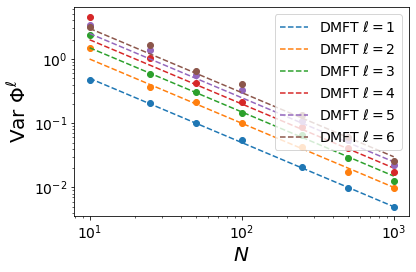

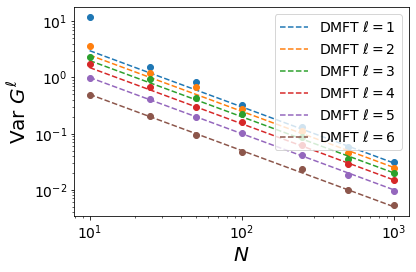

In [111]:
for l in range(L):
    plt.loglog(Nvals, all_cov[:,l], 'o',color = 'C%d' % l)
    plt.loglog(Nvals, all_cov_th[:,l], '--', color = 'C%d' % l, label = 'DMFT $\ell=%d$' % (l+1))
plt.xlabel(r'$N$',fontsize = 20)
plt.ylabel(r'Var $\Phi^{\ell}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('dmft_finite_size_phi_var.pdf')
plt.show()

for l in range(L):
    plt.loglog(Nvals, all_cov_g[:,l], 'o',color = 'C%d' % l)
    plt.loglog(Nvals, all_cov_th_g[:,l], '--', color = 'C%d' % l, label = 'DMFT $\ell=%d$' % (l+1))
plt.xlabel(r'$N$',fontsize = 20)
plt.ylabel(r'Var $G^{\ell}$',fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig('dmft_finite_size_G_var.pdf')
plt.show()





In [112]:
print(all_cov_th)
print(all_cov.mean(axis = 1))
print(all_cov_th.mean(axis =1))
print(all_cov_g.mean(axis = 1))
print(all_cov_th_g.mean(axis =1))

[[0.5   1.    1.5   2.    2.5   3.   ]
 [0.2   0.4   0.6   0.8   1.    1.2  ]
 [0.1   0.2   0.3   0.4   0.5   0.6  ]
 [0.05  0.1   0.15  0.2   0.25  0.3  ]
 [0.02  0.04  0.06  0.08  0.1   0.12 ]
 [0.01  0.02  0.03  0.04  0.05  0.06 ]
 [0.005 0.01  0.015 0.02  0.025 0.03 ]]
[2.57499914 0.87132692 0.38008812 0.20724515 0.07644323 0.03530213
 0.01556781]
[1.75   0.7    0.35   0.175  0.07   0.035  0.0175]
[3.55696532 0.83314949 0.41968216 0.18990484 0.07645485 0.0326541
 0.01763096]
[1.75   0.7    0.35   0.175  0.07   0.035  0.0175]
